## 03 random forest model

In [52]:
# imports and libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import plot_tree

pd.options.display.max_colwidth = 400

In [2]:
# seaborn styling
import seaborn as sns

sns.set_context('notebook') # size of text/graph elements
#sns.despine() # takes away axes on charts with no grid
sns.set_style('white') # background of chart color and if grid is present

### import all_witcher_5000 df and format

In [3]:
# pickle in all_witcher_5000 df
with open('dataframes/all_witcher_5000.pkl', mode= 'rb') as pickle_in: 
    all_witcher_5000= pickle.load(pickle_in)

In [4]:
all_witcher_5000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9781 entries, 0 to 4994
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     9781 non-null   object 
 1   title         9781 non-null   object 
 2   selftext      9781 non-null   object 
 3   score         9781 non-null   int64  
 4   upvote_ratio  9781 non-null   float64
 5   num_comments  9781 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 534.9+ KB


In [5]:
# drop index so range is reflective of current total rows, not out of 10000 with removed rows

all_witcher_5000.reset_index(drop= True, inplace= True)

In [6]:
all_witcher_5000

,subreddit,title,selftext,score,upvote_ratio,num_comments
0,Witcher3,Why did CD never patch the Wolf set bug?,This bug has always frustrated me. Why couldn't they ever fix this? The armour is practically unobtainable until NG+. Why didn't they ever patch that bug?,1,1.0,0
1,Witcher3,The heart of the woods quest,"As you may remember/ know, the quest has two choices. I wasn’t really paying attention and picked the way where you kill the 5 wolves and offer it to the woods. And I was just wondering was that the right choice? Everyone except you dies at the end so it’s hard to know",1,1.0,0
2,Witcher3,Bought the complete edition on PS4,I had this in Xbox but ended up moving and left most of my Xbox games behind so I saw the complete edition on sale so I had to snatch this up. I have never beat the game and recently just bought a 40' inch Vizio. . .I feel that this run on the game will be much more beautiful. What is your favorite part of this game? Please no spoilers.,1,1.0,0
3,Witcher3,This merchant will give you 10 crowns minimum for any book! And the higher priced books he will give around 200 up to 350.,,1,1.0,0
4,Witcher3,When will my winter berry’s grow back,Ice tried everything saving and quitting skipping time I’ve been spending hours actually playing the game the plants right next to them are growing back but the winter berry’s won’t,1,1.0,0
...,...,...,...,...,...,...
9776,netflixwitcher,Ciri waiting for her skype partner to show up (from her insta),,1,1.0,0
9777,netflixwitcher,Freya Allan,"Has anyone seen Freya Allan's Instagram? I'm a bit shocked to see that she is 18 because in a lot of her pics she looks like she is in her 30's. Why does she look so old? On the TV show and in her head shots she definitely looks her age, even a bit younger, but on her Instagram she looks so much different. Maybe they do her makeup for the show a lot different than she does hers normally?\n\nAn...",1,1.0,13
9778,netflixwitcher,"Some will say the artistic direction of the show is far below the level of the games, but I disagree. In my opinion the first season has an amazing atmosphere",,1,1.0,69
9779,netflixwitcher,"Some will say the artistic direction of the show is far below the level of the games, but I disagree. In my opinion the first season has an amazing atmosphere",&amp;#x200B;\n\nhttps://preview.redd.it/25979hadxiy41.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=8f525afef2f1804423d9b3921290a57d4b112762\n\nhttps://preview.redd.it/yjapunadxiy41.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=5b515ff677e2878608f1b49b17f486086fd034ec\n\nhttps://preview.redd.it/bpazr6adxiy41.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=98c96fd2b53cef29db0e0d940...,1,1.0,2


### model setup and baseline accuracy

In [7]:
X= all_witcher_5000['title']
y= all_witcher_5000['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
# baseline accuracy
y.value_counts(normalize= True)

Witcher3          0.507719
netflixwitcher    0.492281
Name: subreddit, dtype: float64

### count vectorize data

In [9]:
# instantiate and fit CountVectorizer on df, then transform X_train
cv = CountVectorizer(min_df=2, stop_words= 'english')
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

### model 7: random forest

In [14]:
rfc= RandomForestClassifier()

print(cross_val_score(rfc, X_train_cv, y_train))
print(cross_val_score(rfc, X_train_cv, y_train).mean())

[0.82481254 0.80231766 0.78732106 0.80845262 0.79345603]
0.8016359918200407


In [25]:
# grid search over random forest model
grid= {
    'n_estimators': np.linspace(110, 150, 9).astype(int),
    'max_depth': [None, 5, 10],
    'min_samples_split': [5, 10, 15]
} 

gs_cv_rfc= GridSearchCV(rfc, param_grid= grid, verbose= 1)
gs_cv_rfc.fit(X_train_cv, y_train)

gs_cv_rfc.best_score_, gs_cv_rfc.best_params_ 

print(f'best score: {gs_cv_rfc.best_score_}')
print(f'best params: {gs_cv_rfc.best_params_}')
print()
print(f'train score: {gs_cv_rfc.score(X_train_cv, y_train)}')
print(f'test score: {gs_cv_rfc.score(X_test_cv, y_test)}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
best score: 0.8184049079754601
best params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 135}

train score: 0.9596455351056578
test params: 0.8295175797219951


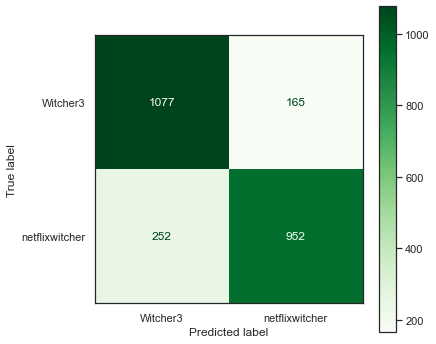

In [120]:
fig, ax = plt.subplots(figsize=(6, 6)) # from https://stackoverflow.com/questions/59839782/confusion-matrix-font-size
plot_confusion_matrix(gs_cv_rfc, X_test_cv, y_test, cmap= 'Greens', ax= ax);

In [167]:
tn, fp, fn, tp= 1077, 165, 252, 952

spec = tn / (tn + fp)
print(f'specificity:{round(spec, 3)}')

sens = tp / (tp + fn)
print(f'sensitivity: {round(sens, 3)}')

acc= (tn + tp) / (tp + tn + fp + fn)
print(f'accuracy: {round(acc, 3)}')

specificity:0.867
sensitivity: 0.791
accuracy: 0.83


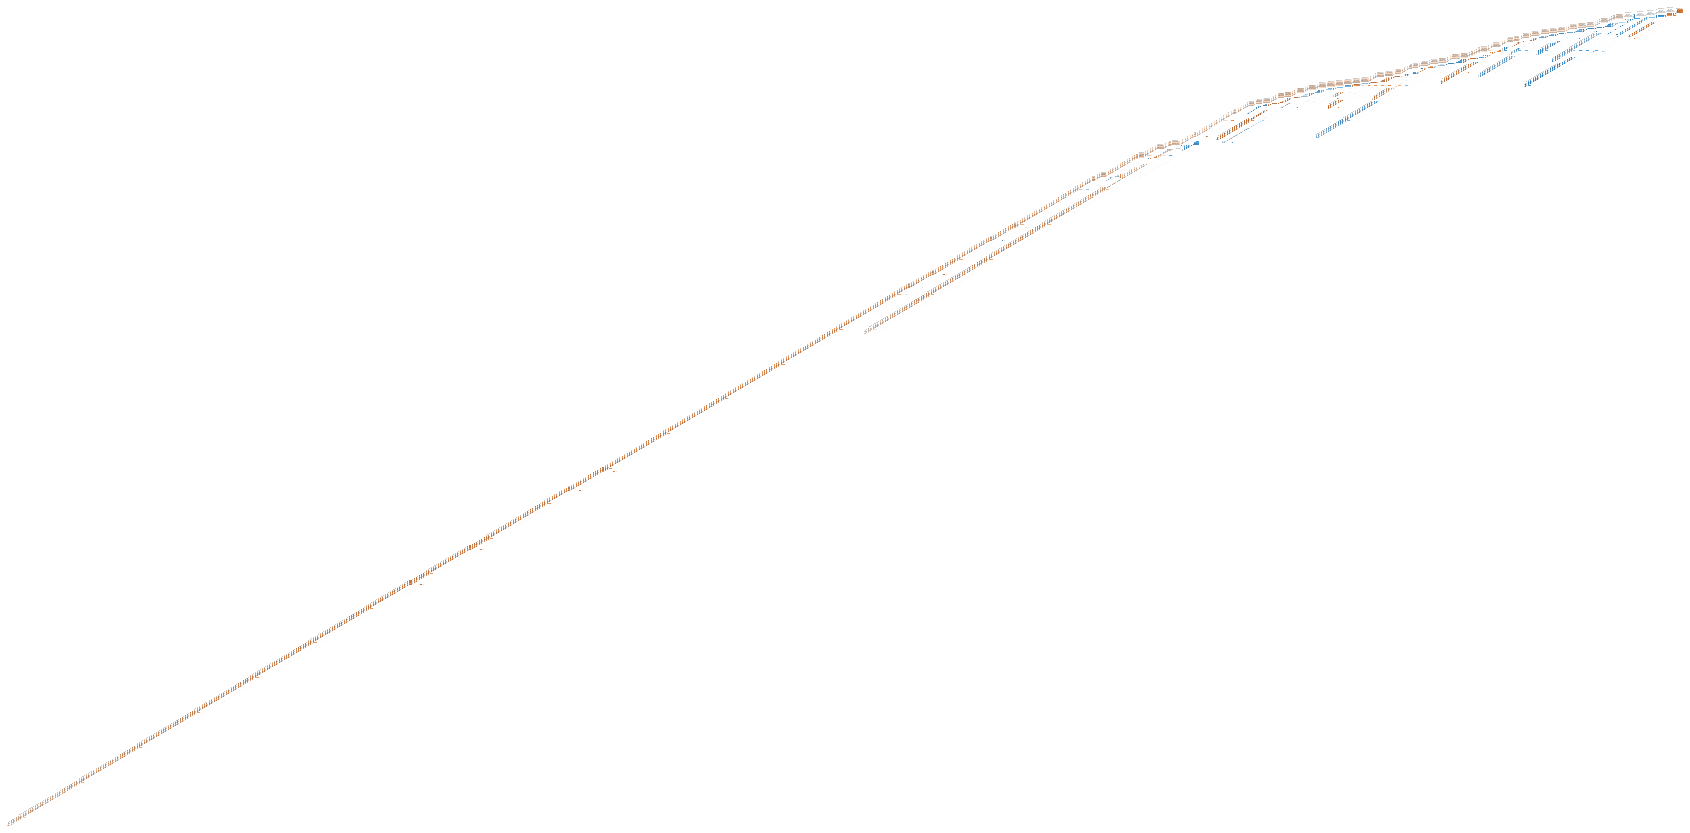

In [54]:
# plot of random forest tree

plt.figure(figsize= (30,15))
plot_tree(gs_cv_rfc_coeff.estimators_[0], filled=True); # plot tree [num]

### misclassification analysis

In [116]:
# predictions
test_preds= gs_cv_rfc.predict(X_test_cv)

# copy of testing df so we can look at misclassifications
misclass= X_test.copy().to_frame()

In [117]:
# add true class and predicted class columns to misclass df
misclass['true_class']= y_test.values
misclass['predicted_class']= test_preds

misclass_df= misclass[misclass['true_class'] != misclass['predicted_class']]

misclass_df.shape # how many posts were misclassified

In [178]:
misclass_df.sort_values(by= 'predicted_class').head(50) # for looking at subset of missclassed data

,title,true_class,predicted_class
6157,I was excited for this show before they ruined it.,netflixwitcher,Witcher3
6346,Damn that baby kinda looks like Daniel Craig 😂,netflixwitcher,Witcher3
5974,This should could have been amazing if they slowed things right down and based it on how it happens in the books. This show is in one big rush. If the first few seasons of Game of Thrones were rushed like this everyone would have hated it. Why rush and over complicate this wonderful story?,netflixwitcher,Witcher3
6052,Why were the witchers depicted like this?,netflixwitcher,Witcher3
5288,I feel like it's weird they make Ciri look like an adult but still talk to her like a child. It's jarring and breaks immersion every time they address her like the 12 year old she is.,netflixwitcher,Witcher3
5273,Favourite moment? I thoughts this was hands down the moment when I got chills.,netflixwitcher,Witcher3
8034,Come lay next to me [f] ❤️,netflixwitcher,Witcher3
9198,THIS IS THE WAY. — THE MANDALORIANS,netflixwitcher,Witcher3
6127,"Next up, The Princess Ninja!",netflixwitcher,Witcher3
8700,Crossover where they just share parenting tips,netflixwitcher,Witcher3


In [169]:
# look at misclassified posts based on specific words

words= ['dandelion', 'jaskier', 'cosplay', 'gwent', 'yennefer']

misclass_words= pd.DataFrame()

for word in words:
    mc_words= misclass_df[misclass_df['title'].str.lower().str.contains(word)]
    misclass_words= misclass_words.append(mc_words, ignore_index= True)

misclass_words